In [1]:
import jupyter_black

import sys, os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid, save_image

import lightning.pytorch as pl

jupyter_black.load()


if "/usr/src" not in sys.path:
    sys.path.append("/usr/src")

In [9]:
# Import custom modules

import helper_plots as hplt
from helper_train import count_fid_metric
import dataset

from models.encoder import Encoder
from models.decoder import Decoder
from models.vae import VariationalAutoEncoder

## Settings

In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
RANDOM_SEED = 111
LEARNING_RATE = 0.0005
NUM_EPOCHS = 200
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS = 1
LATENT_SIZE = 4
RECONSTRUCTION_TERM_WEIGHT = 1

## Dataset

In [4]:
# Directory with source data

cells_dir = "/usr/src/data/separated_bacterias"
samples_dir = "/usr/src/samples"

transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        dataset.CellPadResize(IMAGE_SIZE),
        transforms.ToTensor(),
    ]
)

dataset = dataset.ImageDataset(cells_dir, "cell", transform=transform)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
# Check dataset and trainloader

print(f"Len of dataset:  {len(dataset)} images")
print(f"Len of trainloader:  {len(train_loader)} batches")
print(f"Shape of batch:  {next(iter(train_loader)).shape}")

Len of dataset:  1910 images
Len of trainloader:  15 batches
Shape of batch:  torch.Size([128, 1, 64, 64])


In [6]:
encoder = Encoder(IMAGE_SIZE, LATENT_SIZE, DEVICE)
decoder = Decoder(IMAGE_SIZE, LATENT_SIZE)

vae = VariationalAutoEncoder(encoder, decoder, LEARNING_RATE).to(DEVICE)

In [7]:
trainer = pl.Trainer(max_epochs=100, log_every_n_steps=4)
trainer.fit(vae, train_dataloaders=train_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To prope

/opt/conda/envs/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


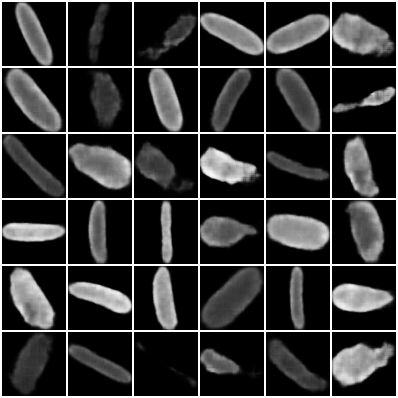

In [8]:
# Create grid of generated samples and show it

samples = hplt.show_grid_samples(vae, 36, "grid_cells_vae")

In [40]:
hplt.generate_and_save_samples(samples_dir, 20, 20, vae, IMAGE_SIZE)

In [11]:
count_fid_metric(train_loader, vae, IMAGE_SIZE, LATENT_SIZE, CHANNELS)

1024 samples are generated, time = 0.905 sec
FID is computed, time = 76.156 sec


tensor(69.4435)